In [1]:
import os
import pickle

import pandas as pd
import numpy as np
from jax import random
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from hbmep.config import Config
from hbmep.model.utils import Site as site

from models import HBe
from constants import (
    TOML_PATH,
    DATA_PATH,
    BUILD_DIR,
    INFERENCE_FILE
)

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False


In [2]:
def load(key, build_dir, ref=0, ref2=0):
    src = os.path.join(build_dir, INFERENCE_FILE)
    with open(src, "rb") as f:
        df, encoder_dict, model_dict, posterior_samples, = pickle.load(f)

    src = os.path.join(build_dir, "model.pkl")
    with open(src, "rb") as f:
        model, = pickle.load(f)

    param = posterior_samples["a_delta_loc"]
    print(param.shape)
    print(f"Reference: {encoder_dict[model.features[1]].classes_[0]}")
    print([
        (c, cat) for c, cat in enumerate(encoder_dict[model.features[1]].classes_[1:])
    ])
    print()

    plt.figure(figsize=(5, 3))
    for j in range(param.shape[-1]):
        sns.kdeplot(param[:, j], label=f"{j} {encoder_dict[model.features[1]].classes_[j + 1]}")
    plt.axvline(x=0, color="black", linestyle="--")
    plt.legend(loc="upper right");

    for j in range(param.shape[-1]):
        if j == ref: continue
        num_iters = 10
        prob = 0
        for _ in range(num_iters):
            key, subkey = random.split(key)
            l = random.permutation(subkey, param[:, ref])
            key, subkey = random.split(key)
            r = random.permutation(subkey, param[:, j])
            l = np.array(l)
            r = np.array(r)
            prob += (l < r).mean()
        prob /= num_iters

        print(f"{j} Pr. ( {encoder_dict[model.features[1]].classes_[ref + 1]} < {encoder_dict[model.features[1]].classes_[j + 1]} ) = {prob}")

    print()
    for j in range(param.shape[-1]):
        if j == ref2: continue
        num_iters = 10
        prob = 0
        for _ in range(num_iters):
            key, subkey = random.split(key)
            l = random.permutation(subkey, param[:, ref2])
            key, subkey = random.split(key)
            r = random.permutation(subkey, param[:, j])
            l = np.array(l)
            r = np.array(r)
            prob += (l > r).mean()
        prob /= num_iters

        print(f"{j} Pr. ( {encoder_dict[model.features[1]].classes_[ref2 + 1]} > {encoder_dict[model.features[1]].classes_[j + 1]} ) = {prob}")
    return key, df, encoder_dict, model, posterior_samples


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(4000, 4)
Reference:  -C___Biphasic
[(0, 'C-X___Biphasic'), (1, 'C-X___Pseudo-Mono'), (2, 'X-C___Biphasic'), (3, 'X-C___Pseudo-Mono')]

1 Pr. ( C-X___Biphasic < C-X___Pseudo-Mono ) = 1.0
2 Pr. ( C-X___Biphasic < X-C___Biphasic ) = 0.92935
3 Pr. ( C-X___Biphasic < X-C___Pseudo-Mono ) = 0.918225

0 Pr. ( C-X___Pseudo-Mono > C-X___Biphasic ) = 1.0
2 Pr. ( C-X___Pseudo-Mono > X-C___Biphasic ) = 1.0
3 Pr. ( C-X___Pseudo-Mono > X-C___Pseudo-Mono ) = 1.0


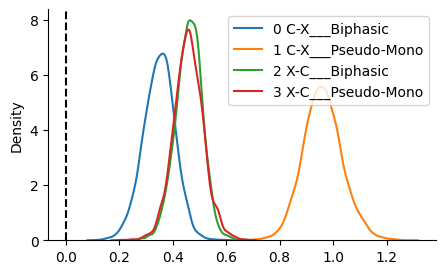

In [3]:
key = random.PRNGKey(0)
build_dir = "/home/vishu/repos/rat-mapping-paper/reports/log-hierarchical/L_SHIE/mvn_reference/4000W_4000S_4C_4T_20D_0.95A_mixtureFalse/no-ground"
key, df, encoder_dict, model, posterior_samples = load(key, build_dir, ref=0, ref2=1)

(4000, 3)
Reference:  -C___Biphasic
[(0, '-C___Pseudo-Mono'), (1, 'C-___Biphasic'), (2, 'C-___Pseudo-Mono')]

0 Pr. ( C-___Biphasic < -C___Pseudo-Mono ) = 0.826875
2 Pr. ( C-___Biphasic < C-___Pseudo-Mono ) = 1.0

0 Pr. ( C-___Pseudo-Mono > -C___Pseudo-Mono ) = 1.0
1 Pr. ( C-___Pseudo-Mono > C-___Biphasic ) = 1.0


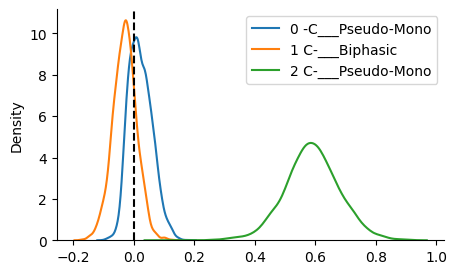

In [4]:
build_dir = "/home/vishu/repos/rat-mapping-paper/reports/log-hierarchical/L_SHIE/mvn_reference/4000W_4000S_4C_4T_20D_0.95A_mixtureFalse/with-ground"
key, df, encoder_dict, model, posterior_samkles = load(key, build_dir, ref=1, ref2=2)


(4000, 7)
Reference:  -C___Biphasic
[(0, '-C___Pseudo-Mono'), (1, 'C-X___Biphasic'), (2, 'C-X___Pseudo-Mono'), (3, 'C-___Biphasic'), (4, 'C-___Pseudo-Mono'), (5, 'X-C___Biphasic'), (6, 'X-C___Pseudo-Mono')]

0 Pr. ( C-___Biphasic < -C___Pseudo-Mono ) = 0.91415
1 Pr. ( C-___Biphasic < C-X___Biphasic ) = 0.9999750000000001
2 Pr. ( C-___Biphasic < C-X___Pseudo-Mono ) = 1.0
4 Pr. ( C-___Biphasic < C-___Pseudo-Mono ) = 1.0
5 Pr. ( C-___Biphasic < X-C___Biphasic ) = 1.0
6 Pr. ( C-___Biphasic < X-C___Pseudo-Mono ) = 1.0

0 Pr. ( C-X___Pseudo-Mono > -C___Pseudo-Mono ) = 1.0
1 Pr. ( C-X___Pseudo-Mono > C-X___Biphasic ) = 1.0
3 Pr. ( C-X___Pseudo-Mono > C-___Biphasic ) = 1.0
4 Pr. ( C-X___Pseudo-Mono > C-___Pseudo-Mono ) = 0.9920249999999999
5 Pr. ( C-X___Pseudo-Mono > X-C___Biphasic ) = 1.0
6 Pr. ( C-X___Pseudo-Mono > X-C___Pseudo-Mono ) = 1.0


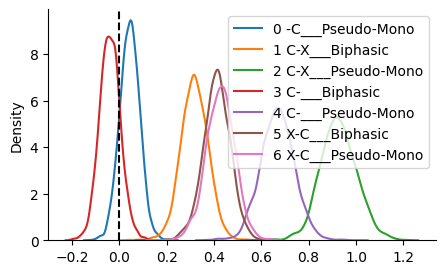

In [5]:
build_dir = "/home/vishu/repos/rat-mapping-paper/reports/log-hierarchical/L_SHIE/mvn_reference/4000W_4000S_4C_4T_20D_0.95A_mixtureFalse/all"
key, df, encoder_dict, model, posterior_samkles = load(key, build_dir, ref=3, ref2=2)
